Playing with Features
==================

Some attempts to pre-process the features in order to improve learning methods. 



In [32]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

%load_ext autoreload
%autoreload 2
%matplotlib inline


import numpy as np
import pandas as pd
#import lightgbm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import decomposition as skdecomp
from sklearn import ensemble as skensemble
from sklearn import tree as sktree
from sklearn import metrics as skmetrics

import os
import time
import matplotlib.pyplot as plt

from load import DataWorker

N_FEATURE_DIMENSIONS = 20

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def get_color_sequence(y):
    cs = []
    for value in y:
        if value == 0:
            col = "b"
        else:
            col = "r"
        cs.append(col)
    return cs

class WeightedPredictionEnsemble(skensemble.BaggingClassifier):

    def __init__(self, **kwargs):
        self.weight_one = kwargs.pop("weight_one", 1) #default value is 1
        super(WeightedPredictionEnsemble, self).__init__(**kwargs)

    def predict(self, X):
        weight_sum = np.zeros(np.shape(X)[0])
        avg_prediction = np.zeros(np.shape(X)[0])
        for clf in self.estimators_:
            results = clf.predict(X)
            results = results.astype(float)
            
            weight_sum[np.where(results == 0)] += 1
            weight_sum[np.where(results == 1)] += self.weight_one

            results[np.where(results == 1)] *= self.weight_one
            avg_prediction += results

        final = avg_prediction / weight_sum
        final[np.where(final >= 0.5)] = 1
        final[np.where(final < 1)] = 0

        return final


In [12]:
dw = DataWorker() # load all the data
x, y, test = dw.get_normalized_production_set()

Text(0.5, 1.0, 'PCA: Training and Test Data')

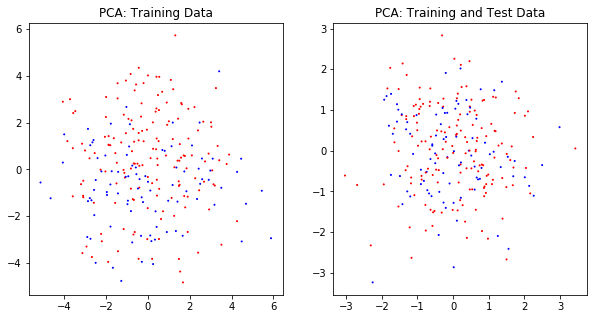

In [23]:
# Use PCA on the trainin features and on the combined set of training and test features
pca_a = skdecomp.PCA(n_components=N_FEATURE_DIMENSIONS)
pca_b = skdecomp.PCA(n_components=N_FEATURE_DIMENSIONS)
pca_a.fit(x)
pca_b.fit(np.append(x,test,axis=0))

coords_a = pca_a.transform(x)
coords_b = pca_b.transform(x)

color_sequence = get_color_sequence(y)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,0], coords_a[:,1], s=1, c=color_sequence)
plt.title("PCA: Training Data")

plt.subplot(1,2,2)
plt.scatter(coords_b[:,0], coords_b[:,1], s=1, c=color_sequence)
plt.title("PCA: Training and Test Data")




/home/jc/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/home/jc/miniconda2/envs/py37/lib/python3.7/site-packages/sklearn/decomposition/fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Text(0.5, 1.0, 'ICA: Training and Test Data')

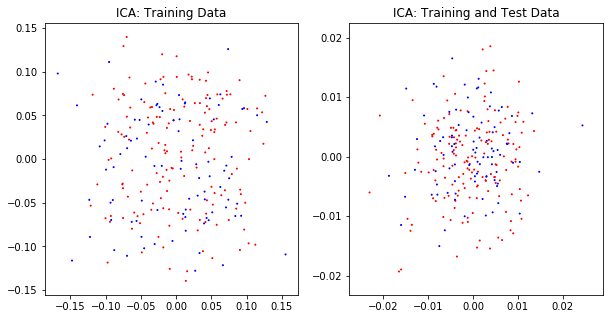

In [30]:
# Use ICA, maybe the basis is heavily correlated?
ica_a = skdecomp.FastICA(n_components=N_FEATURE_DIMENSIONS, max_iter=10000)
ica_b = skdecomp.FastICA(n_components=N_FEATURE_DIMENSIONS, max_iter=10000)
ica_a.fit(x)
ica_b.fit(np.append(x,test,axis=0))

coords_a = ica_a.transform(x)
coords_b = ica_b.transform(x)

color_sequence = get_color_sequence(y)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.scatter(coords_a[:,0], coords_a[:,1], s=1, c=color_sequence)
plt.title("ICA: Training Data")

plt.subplot(1,2,2)
plt.scatter(coords_b[:,0], coords_b[:,1], s=1, c=color_sequence)
plt.title("ICA: Training and Test Data")

Okay, I think we're getting somewhere. It looks like the ICA and PCA on the data set works better when fitting only on the training data. Especially with the separation of red (1 values). However, these values are still very mixed. Let's compute some validation scores with the fitting methods and see if one method or the other trains better.

In [38]:
# Previously, we found these hyper parametesr to be pretty good for learning
# Note, previous models were not found to be sensitive to the max_features parameters
# Therefore, a smaller value of max_features is used in dimensional reduction
best_forest = WeightedPredictionEnsemble(base_estimator=sktree.DecisionTreeClassifier(max_features=N_FEATURE_DIMENSIONS, 
                                            class_weight={0:1,1:0.56}), 
                                       n_estimators=1000, 
                                       max_samples=150, 
                                       weight_one=0.56)

In [47]:
x_reduced_list = []
x_reduced_list.append(pca_a.transform(x))
x_reduced_list.append(pca_b.transform(x))
x_reduced_list.append(ica_a.transform(x))
x_reduced_list.append(ica_b.transform(x))
for x_mod in x_reduced_list: 
    x_train, x_val, y_train, y_val = train_test_split(x_mod, y, test_size=0.2, random_state=23, stratify=y) 
    best_forest.fit(x_train, y_train)
    y_predicted = best_forest.predict(x_val)

    score = skmetrics.accuracy_score(y_val, y_predicted)
    
    print(score)



0.68
0.48
0.6
0.46


In [48]:
best_forest.fit(pca_a.transform(x), y)
submission_predictions = best_forest.predict(pca_a.transform(test))
dw.output_results(submission_predictions, savename="submission_rf_pca.csv")

Classified as zero: 13026, 0.659544
 Classified as one: 6724, 0.340456
